Thanks to [Reference](https://towardsdatascience.com/statistical-inference-in-pyhton-using-pandas-numpy-part-i-c2ac0320dffe)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pipeline-accidents/database.csv


In [3]:
import pandas as pd

data = pd.read_csv('/kaggle/input/pipeline-accidents/database.csv')
cols_of_interest = ['Accident Date/Time','Accident State','Pipeline Location','Liquid Type','Net Loss (Barrels)','All Costs']
data = data[cols_of_interest] #remove columns not needed for this analysis
print(data.head())

  Accident Date/Time Accident State Pipeline Location  \
0   1/1/2010 7:15 AM             KS           ONSHORE   
1   1/4/2010 8:30 AM             ME           ONSHORE   
2  1/5/2010 10:30 AM             LA           ONSHORE   
3   1/6/2010 7:30 PM             WI           ONSHORE   
4   1/7/2010 1:00 PM             TX           ONSHORE   

                                  Liquid Type  Net Loss (Barrels)  All Costs  
0  HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS                21.0       1627  
1                                   CRUDE OIL                 0.0       4008  
2  HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS                 2.0        200  
3                                   CRUDE OIL                 0.0      11540  
4                                   CRUDE OIL                 2.0      29650  


In [4]:
data_summary = data[['All Costs','Net Loss (Barrels)']].describe()

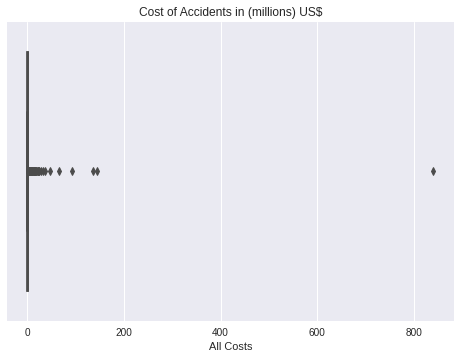

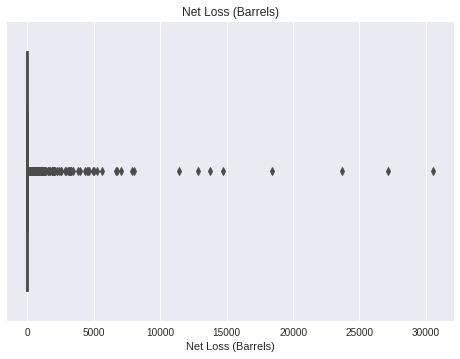

In [5]:
import seaborn  as sns
import matplotlib.pyplot as plt

data['All Costs'] = data['All Costs'] / 1000000

plt.style.use('seaborn')

_ = sns.boxplot(data['All Costs'], data=data)
_ = plt.title('Cost of Accidents in (millions) US$')
plt.show()
plt.close()

__ = sns.boxplot(data['Net Loss (Barrels)'], data=data)
__ = plt.title('Net Loss (Barrels)')

plt.show()

In [6]:
import numpy as np
data['Accident Date/Time'] = pd.to_datetime(data['Accident Date/Time'])
totaltimespan = np.max(data['Accident Date/Time']) - np.min(data['Accident Date/Time'])

totaltime_hour = (totaltimespan.days*24 + totaltimespan.seconds/(3600))
totaltime_month = (totaltimespan.days + totaltimespan.seconds/(3600*24)) *12/365

lmda_h = len(data) / totaltime_hour
lmda_m = len(data) / totaltime_month 

print('Estimated no. of accidents per hour: {}'.format(lmda_h)) 
print('Estimated no. of accidents per month: {}'.format(lmda_m))

Estimated no. of accidents per hour: 0.04540255169379675
Estimated no. of accidents per month: 33.14386273647162


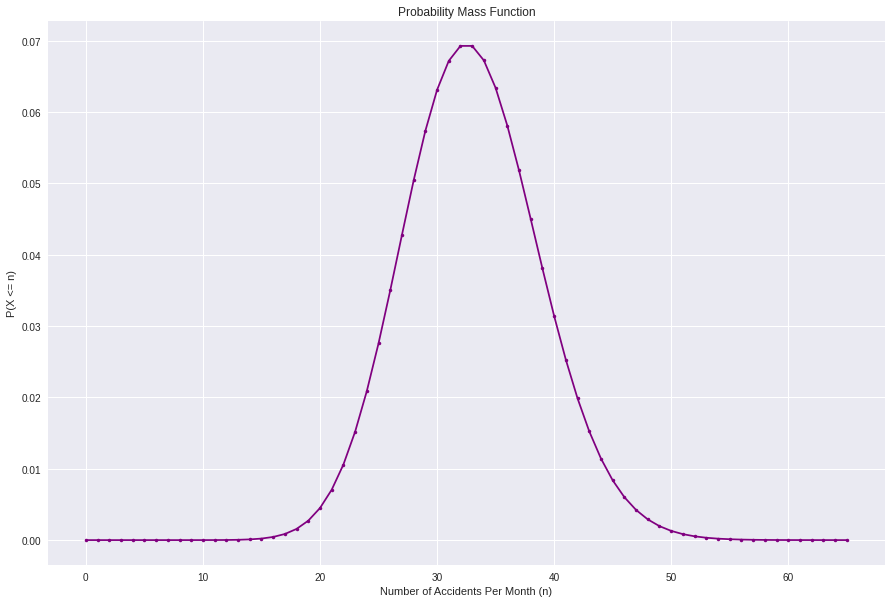

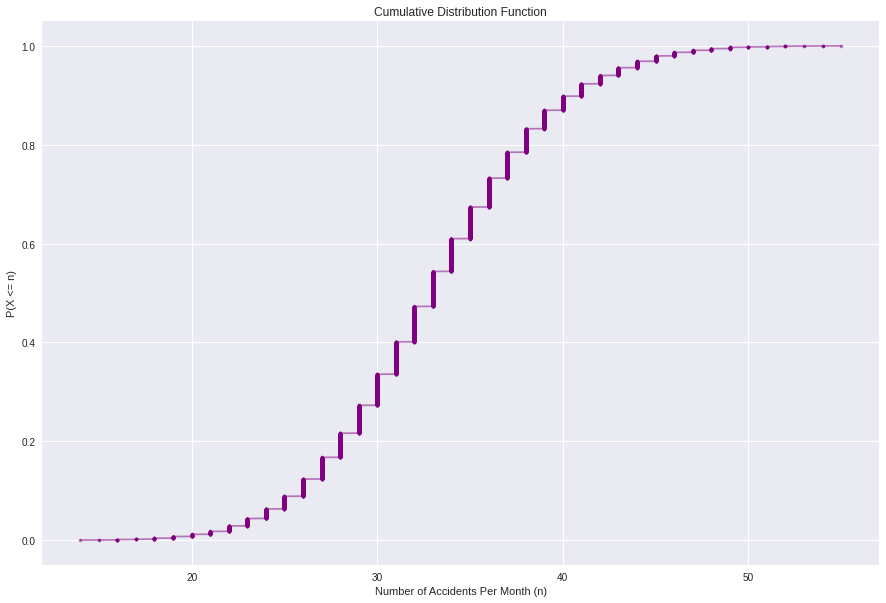

In [7]:
import math
import matplotlib.pyplot as plt

X = {} 
for i in range(66): #calculate probabilities for each value of n between 0 and 66
    X[i] = math.pow(2.71828,-1*33) * math.pow(33,i)/math.factorial(i)

p_poisson = pd.DataFrame(X.items(), columns=['X','PX'])

plt.style.use('seaborn')

fig = plt.subplots(figsize = (15,10))
_ = plt.plot(p_poisson['X'],p_poisson['PX'] , marker='.', color = 'purple', linestyle='solid')
plt.xlabel('Number of Accidents Per Month (n)')
plt.ylabel('P(X <= n)')
plt.title('Probability Mass Function')
plt.show()

plt.close()

def cdf(data): #form a cumulative distribution function for data
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

np.random.seed(42)
samples_poisson = np.random.poisson(33,10000) #select a random sample of 3000 from a Poisson Distribution with mean = 33

x,y = cdf(samples_poisson) 

fig = plt.subplots(figsize = (15,10))
_ = plt.plot(x, y, marker='.', alpha = 0.5, color = 'purple', linestyle='solid')
plt.xlabel('Number of Accidents Per Month (n)')
plt.ylabel('P(X <= n)')
plt.title('Cumulative Distribution Function')
plt.show()

Mean time between accidents (h): 22.03307683130523


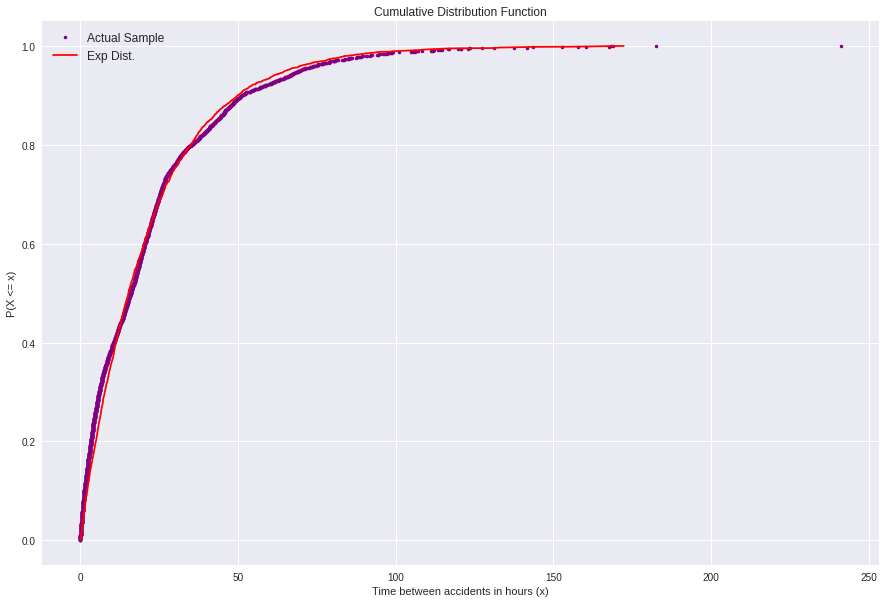

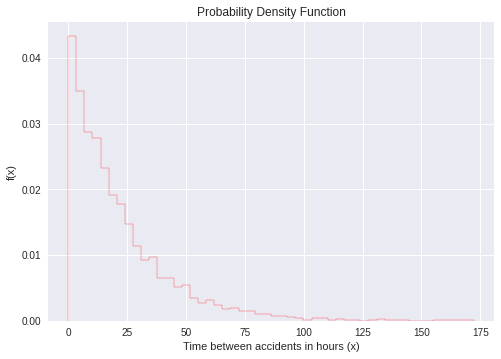

In [8]:
data.sort_values(by=['Accident Date/Time'], ascending = True, inplace = True)
data['timetoAccident'] = data['Accident Date/Time'].diff() #compute time between each accident
data['timetoAccident_h'] = data.apply(lambda x: x['timetoAccident'].days * 24 + x['timetoAccident'].seconds/3600, axis = 1)
data= data[data.timetoAccident.notnull()]

mean = np.mean(data['timetoAccident_h']) #parameter for exponential distribution

print('Mean time between accidents (h): {0}'.format(mean))



x,y = cdf(data['timetoAccident_h']) #cumulative distribution for accidents data

samples_exp =np.random.exponential(mean,size=3000) #random sample from exponential distribution
x_theor_exp,y_theor_exp = cdf(samples_exp)

fig = plt.subplots(figsize = (15,10))
_ = plt.plot(x, y, label = 'Actual Sample', marker='.', linestyle='none', color = 'purple')
_ = plt.plot(x_theor_exp, y_theor_exp,label = 'Exp Dist.', color = 'red', linestyle='solid')
_ = plt.legend(fontsize = 'large')
_ = plt.xlabel('Time between accidents in hours (x)')
_ = plt.ylabel('P(X <= x)')
plt.title('Cumulative Distribution Function')
plt.show()

plt.close()

__ = plt.hist(samples_exp, bins = 50, density = True, histtype = 'step', color = 'red')
__ = plt.xlabel('Time between accidents in hours (x)')
__ = plt.ylabel('f(x)')
__ = plt.title('Probability Density Function')
plt.show()

plt.close()

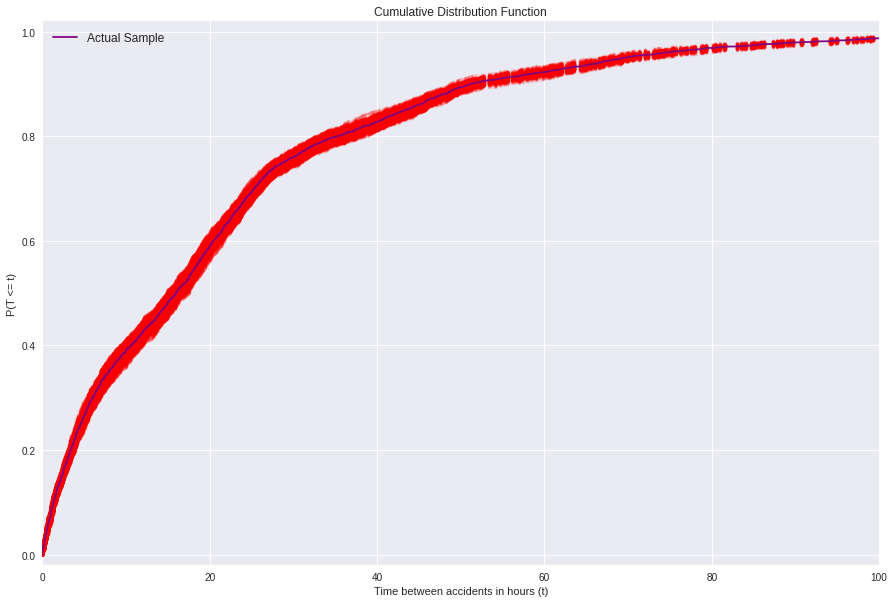

In [9]:
fig = plt.subplots(figsize = (15,10))
___ =plt.gca()
___.set_xlim([0,100])

for a in range(100):
    bs_sample = np.random.choice(data['timetoAccident_h'], size=len(data['timetoAccident_h']))
    x, y = cdf(bs_sample)
    ___ = plt.plot(x, y, marker='.', linestyle = 'none',
                 color='red', alpha=0.1)

x, y = cdf(data['timetoAccident_h'])
___ = plt.plot(x, y, label = 'Actual Sample', color = 'purple',linestyle = 'solid')

___ = plt.margins(0.02)
___ = plt.legend(fontsize = 'large')
___ = plt.xlabel('Time between accidents in hours (t)')
___ = plt.ylabel('P(T <= t)')
plt.title('Cumulative Distribution Function')
plt.show()

plt.savefig('bssamples.png')

plt.close()

95% confidence interval = [21.15700728 22.9357531 ] hours


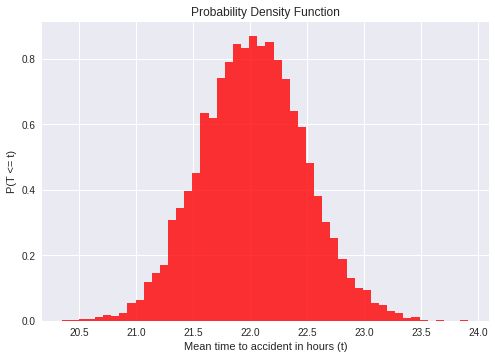

In [10]:
def bootstrap_replicate_1d(data, func):
    #Generate bootstrap replicate of 
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    #Draw bootstrap replicates

    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

bs_replicates = draw_bs_reps(data['timetoAccident_h'], np.mean, size=10000)

conf_int = np.percentile(bs_replicates,[2.5, 97.5])
print('95% confidence interval =', conf_int, 'hours')


____ = plt.hist(bs_replicates, bins=50, density=True, alpha = .8, color = 'red')
____ = plt.xlabel('Mean time to accident in hours (t)')
____ = plt.ylabel('P(T <= t)')
____ = plt.title('Probability Density Function')

plt.show()